### Case 2 - Computational Data Analysis

#### UTKFaces dataset:

We use the clean version of the data (cropped and aligned) as given in the provided 'data.zip' file. 

- Faces: contains 23705 aligned and cropped images of shape (200 x 200 x 3) i.e. (Height x Width x Channel).
- labels.csv: labels of the images in the same order as the images in the 'Faces' folder; given in comma separated format as: age, gender, race.
- filenames.txt: original filenames of the images in the same order as the images and the labels.

#### Usual imports:

In [1]:
import os
import numpy as np
import skimage
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from skimage.io import imread,imshow
from skimage.color import rgb2gray 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier

#### Upload data:

<font color='red'> I get MemoryError so I am working with a smaller dataset of 5000 images </font>

In [2]:
# Upload all images in a multidimensional array (Number of images x Height x Width x Channels):

path_faces = 'C:\\Users\\s210289\\COMP_DATA_ANALYSIS_CASE2\\data\\Faces'
path_labels = 'C:\\Users\\s210289\\COMP_DATA_ANALYSIS_CASE2\\data\\labels.csv'

def load_images(folder):
    images = []
    # n_imgs = len(os.listdir(folder))  
    n_imgs = 5000
    for filename in range(n_imgs):
        img = mpimg.imread(os.path.join(folder, str(filename)+'.jpg'))
        if img is not None:
            images.append(img)
    return images

dataimgs = np.array(load_images(path_faces))
    
# labels on 'age', 'gender', and 'race' diven for each image. 

labels = pd.read_csv(path_labels,names=['age','gender','race'])

# We do not need the information in 'filenames.txt'

In [3]:
print(labels)

       age  gender  race
0      100       0     0
1      100       0     0
2      100       1     0
3      100       1     0
4      100       1     0
...    ...     ...   ...
23700    9       1     3
23701    9       1     3
23702    9       1     4
23703    9       1     4
23704    9       1     4

[23705 rows x 3 columns]


In [4]:
n_imgs = dataimgs.shape[0]
height = dataimgs.shape[1]
width = dataimgs.shape[2]
channels = dataimgs.shape[3]

print("Number of images: ",n_imgs)
print("Height: ", height)
print("Width: ", width)
print("Number of channels: ", channels)

Number of images:  5000
Height:  200
Width:  200
Number of channels:  3


Our objective would be to classify the images with the data features that have been reduced by PCA or LDA. Then, we can use K-Nearest Neighbors (KNN) algorithm to classify the image classes. 

### PCA

When performing PCA on images, we need to construct a 'flat' vactor of features, where the intensity of every pixel of an image is a feature (i.e. each image is represented as a vector instead of as a matrix). There should be no problem on using a RGB image in PCA by creating a vector of 200x200x3 features for each image, but for now, we decided to work in grayscale to reduce the dimensions of the problem and avoid MemoryErrors.

In [5]:
graydata = rgb2gray(dataimgs)

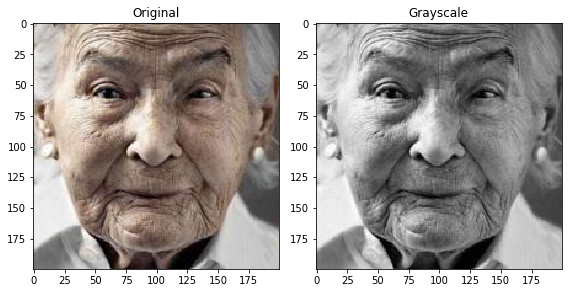

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(dataimgs[9])
ax[0].set_title("Original")
ax[1].imshow(graydata[9], cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

In [7]:
# Flatten the data: 
images = np.reshape(graydata, (n_imgs, height * width))

The idea of PCA consists on a linear transformation of data: S = XL; where we find an orthogonal transformation by the L rotation matrix over the data X, obtaining the transformed data S (score matrix) which will have maximum variance (i.e., minimum mean square error (MSE)).

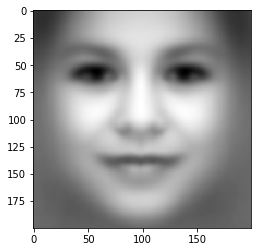

In [8]:
# mean of the data: 
img_mean = np.mean(images, axis = 0)
plt.imshow(np.reshape(img_mean,(height,width)), cmap = "gray")

<font color='red'> Decide if for centering the data we should also divide by std </font> 

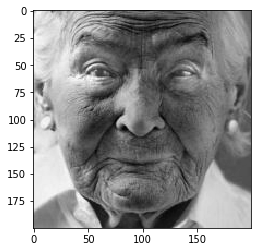

In [9]:
# Center the data (substract mean)  (????????????? Also divide by std?)
centered_imgs = images - img_mean
plt.imshow(np.reshape(centered_imgs[9],(height,width)), cmap = "gray")

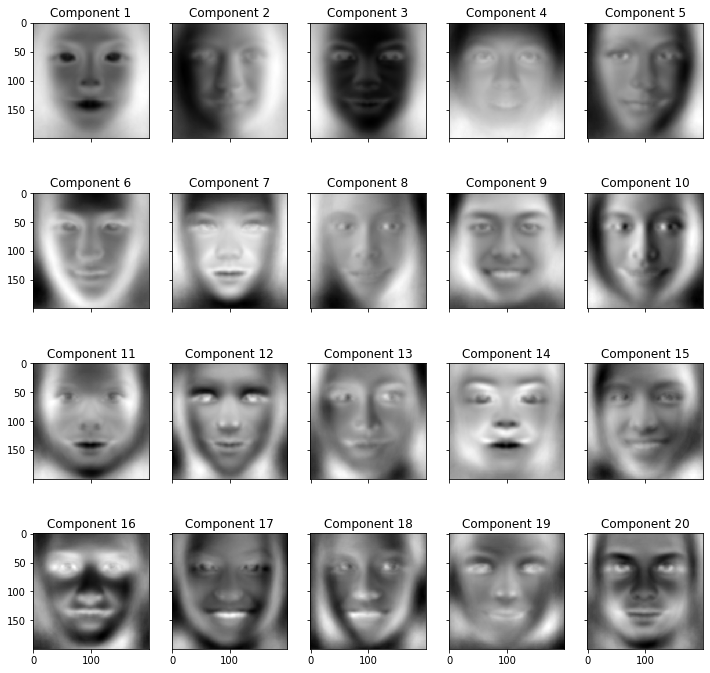

In [10]:
n_features = height*width  # n_components must be between 0 and min(n_samples, n_features)=5000 with svd_solver='full'
n_components = min(5000, n_features) # We could start with a smaller number of features too. 
pca = PCA(n_components=n_components)
S = pca.fit_transform(centered_imgs)
A = pca.components_

# Visually inspect the first 20 PCA components as images:
img_plot = np.reshape(A, (n_components, height, width))

f, axs = plt.subplots(4, 5, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in zip(range(20), axs):
    ax.imshow(img_plot[i,:,:], cmap ='gray')
    ax.set_title('Component ' + str(i+1))
plt.show()

Now we can reconstruct the images with just the number of PCs we are interested in. We can choose this number by defining the certain percentage of explained variance we want to obtain (i.e., 95%) or by making a scree plot, which is the recomended method, and consists on comparing the eigenvalues to those obtained from dantomized data (with same total variance). 

<font color='red'>Find the reason why the percentage of expl var is usually a bad idea (and decide if we keep both and explain or just keep one)</font>

##### Obtain a certain percentage of explained variance

In [11]:
ratio_var = pca.explained_variance_ratio_
var_cumu = np.cumsum(ratio_var)
d=np.argmax(var_cumu>=0.95)+1

print("Number of components explaining 95% variance: ", d)

Number of components explaining 95% variance:  167


Text(0, 0.5, 'Explained variance')

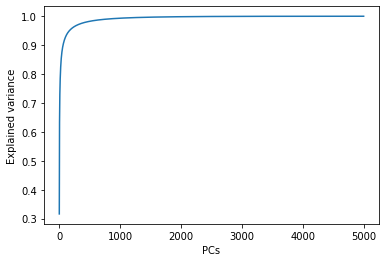

In [12]:
plt.plot(var_cumu);
plt.xlabel("PCs")
plt.ylabel("Explained variance")

In [13]:
images.shape

(5000, 40000)

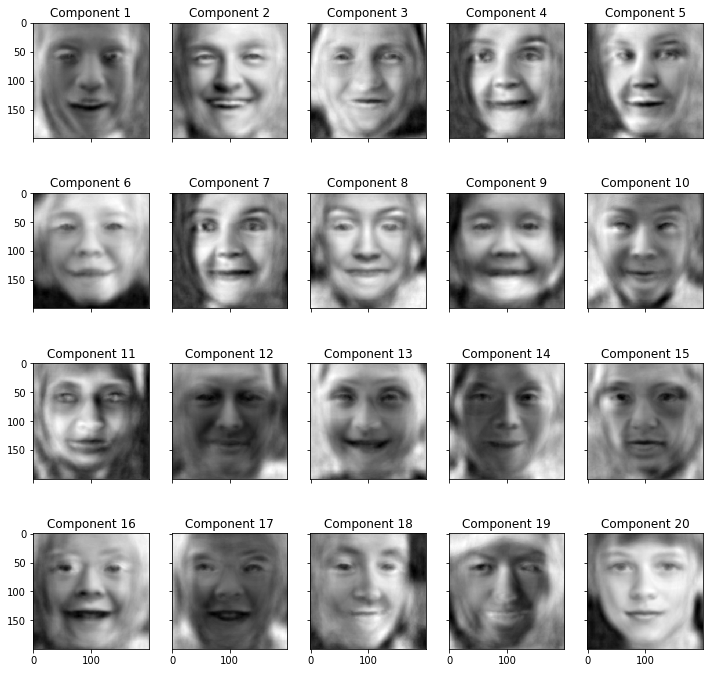

In [14]:
# Reconstruct the images using 167 components:
pca_red = PCA(n_components = d)
S_red = pca_red.fit_transform(centered_imgs)
A_red = pca_red.components_

# Visually inspect the reconstruction of the first 20 images in our dataset:
imgs_reconstr = np.matmul(S_red,A_red) + img_mean
img_plot = np.reshape(imgs_reconstr, (n_imgs, height, width))

f, axs = plt.subplots(4, 5, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in zip(range(20), axs):
    ax.imshow(img_plot[i,:,:], cmap ='gray')
    ax.set_title('Component ' + str(i+1))
plt.show()

<font color='red'> Seems like a bad reconstrucion, like too little PCs, but maybe it works well with this few PCs even if doesn't look so visually. When we run pca with the same number of components in a single image we get much better results. </font>

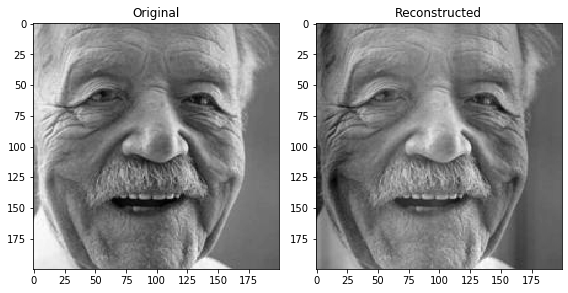

In [15]:
# Reconstruct just one image using 167 components:
pca_red_one = PCA(n_components = d)
S_red_one = pca_red_one.fit_transform(centered_imgs[0].reshape(200,200))
A_red_one = pca_red_one.components_

# Visually inspect the reconstruction of the first 20 images in our dataset:
img_plot = np.matmul(S_red_one,A_red_one) + img_mean.reshape(200,200)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(images[0].reshape(200,200), cmap=plt.cm.gray)
ax[0].set_title("Original")
ax[1].imshow(img_plot, cmap=plt.cm.gray)
ax[1].set_title("Reconstructed")

fig.tight_layout()
plt.show()

#### Using a scree plot

<font color='red'> For that on Lecture 8 slide 20 it is mentioned to make a scree plot and compare eigenvalues to those obtained from randomized data. Can someone elaborate a bit on which the randomized data refers to? </font>

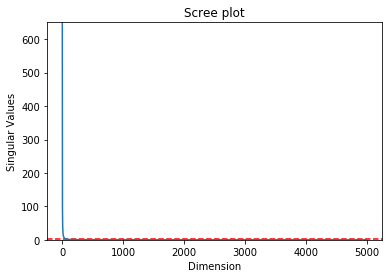

In [16]:
plt.ylabel('Singular Values')
plt.xlabel('Dimension')
plt.title('Scree plot')
plt.ylim(0, max(pca.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=1, color='r', linestyle = '--')
plt.plot(pca.explained_variance_)
plt.show()

<font color='red'> Comments on incremental PCA: dies it affect somehow to our results? because it is used when the data is too large to fit in memory (that's nice) but builds a low-rank spprox. for the input data; maybe this affects to our accuracy? (I see you (Soren) do the normal PCA as 'final PCA', should we keep both or just one? </font>

For now, we have done dimensionality reduction using PCA. 

Now we will try to use KNN algorithm to classify the image classes by 'gender' first. For that we will split our dataset <font color='red'> (that has just 5000 images for now) </font> into training set <font color='red'> (4000 images for now) </font> and test set <font color='red'> (the remaining 1000 images)</font>. 

In [17]:
#Split into train and test datasets: 
idxs_train = random.sample(range(5000), 4000)
idxs_test = [i for i in range(5000) if i not in idxs_train]
imgs_train = centered_imgs[idxs_train]
gender_train = labels['gender'][idxs_train]
imgs_test = centered_imgs[idxs_test]
gender_test = labels['gender'][idxs_test].reset_index(drop=True)

# PCA
n_features = height*width  # n_components must be between 0 and min(n_samples, n_features)=5000 with svd_solver='full'
n_components = min(1000, n_features) # We could start with a smaller number of features too. 
pca = PCA(n_components=n_components)
pca.fit(imgs_train)
imgs_train = pca.fit_transform(imgs_train)
imgs_test = pca.fit_transform(imgs_test)

k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(imgs_train, gender_train) 

gender_predict = knn_model.predict(imgs_test)

count = 0
for i in range(1000):
    if gender_test[i]==gender_predict[i]:
        count += 1
        
accuracy = count/1000

print('Accuracy = ', accuracy)

Accuracy =  0.612


### LDA

In Linear Discriminant Analysis (LDA) instead of maximizing the variance, we will minimize the variance and find the axes that maximize the separation between the class mean.

In [18]:
n_features = height*width
n_components = min(5000, n_features)
lda = LDA(n_components=n_components)
S = lda.fit_transform(centered_imgs)
A = lda.components_

TypeError: fit() missing 1 required positional argument: 'y'

https://benalexkeen.com/k-nearest-neighbours-classification-in-python/
https://www.linkedin.com/pulse/dimensionality-reduction-pca-vs-lda-face-recognition-m-farhan-tandia